In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('HINDUNILVR.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,62.200001,62.575001,61.805000,61.805000,34.943813,11000
1996-01-02,61.805000,62.700001,61.825001,62.465000,35.316959,203500
1996-01-03,62.465000,62.349998,61.799999,62.095001,35.107761,58000
1996-01-04,62.000000,62.299999,61.900002,62.099998,35.110607,111500
1996-01-05,62.099998,62.400002,61.500000,62.000000,35.054058,39500


In [5]:
# to check dates in index
df.index

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=6914, freq=None)

In [6]:
df.shape

(6914, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,2668.649902,2678.000000,2648.699951,2654.350098,2654.350098,830052
2023-06-23,2651.300049,2660.550049,2627.449951,2641.600098,2641.600098,991214
2023-06-26,2642.149902,2674.199951,2642.149902,2652.100098,2652.100098,758700
2023-06-27,2652.100098,2661.600098,2636.000000,2651.350098,2651.350098,687747
2023-06-30,2665.949951,2685.899902,2651.350098,2678.149902,2678.149902,1159828


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6914 entries, 1996-01-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6914 non-null   float64
 1   High       6914 non-null   float64
 2   Low        6914 non-null   float64
 3   Close      6914 non-null   float64
 4   Adj Close  6914 non-null   float64
 5   Volume     6914 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 378.1 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

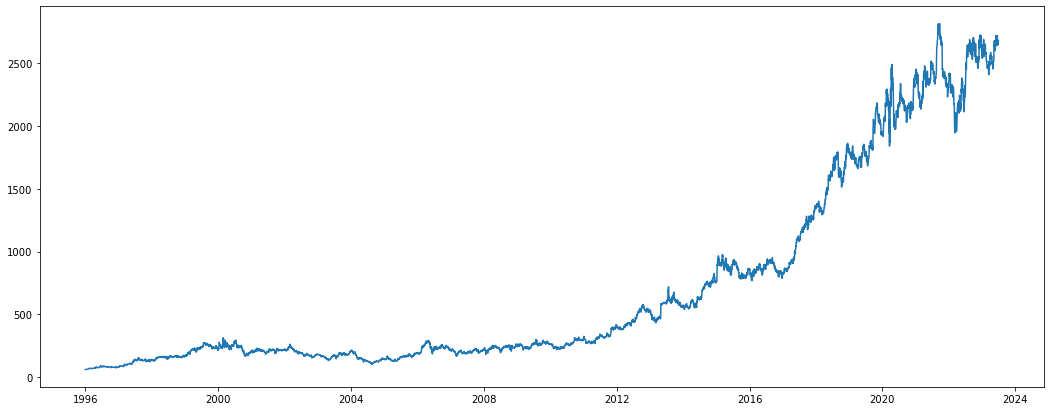

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  62.20000076293945
Ending price:  2678.14990234375


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  1996-01-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
1996-01-01,62.200001,61.805000
1996-01-02,61.805000,62.465000
1996-01-03,62.465000,62.095001
1996-01-04,62.000000,62.099998
1996-01-05,62.099998,62.000000


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00000000e+00],
       [2.39943671e-04],
       [1.05430152e-04],
       ...,
       [9.41704634e-01],
       [9.41431971e-01],
       [9.51175069e-01]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(4839, 2075)

In [21]:
train_data

array([[0.00000000e+00],
       [2.39943671e-04],
       [1.05430152e-04],
       ...,
       [3.19850432e-01],
       [3.16560299e-01],
       [3.07635124e-01]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00000000e+00, 2.39943671e-04, 1.05430152e-04, ...,
        5.58050884e-04, 5.43508507e-04, 5.43508507e-04],
       [2.39943671e-04, 1.05430152e-04, 1.07246909e-04, ...,
        5.43508507e-04, 5.43508507e-04, 7.52550668e-04],
       [1.05430152e-04, 1.07246909e-04, 7.08923537e-05, ...,
        5.43508507e-04, 7.52550668e-04, 9.21600598e-04],
       ...,
       [2.53647785e-01, 2.53865907e-01, 2.53266061e-01, ...,
        3.20959280e-01, 3.28466597e-01, 3.19977688e-01],
       [2.53865907e-01, 2.53266061e-01, 2.52357183e-01, ...,
        3.28466597e-01, 3.19977688e-01, 3.17032911e-01],
       [2.53266061e-01, 2.52357183e-01, 2.53938622e-01, ...,
        3.19977688e-01, 3.17032911e-01, 3.19850432e-01]])

In [25]:
y_train

array([0.00075255, 0.0009216 , 0.00090524, ..., 0.31703291, 0.31985043,
       0.3165603 ])

In [26]:
X_test

array([[0.30867124, 0.30469037, 0.30801685, ..., 0.30005509, 0.31768732,
        0.31552419],
       [0.30469037, 0.30801685, 0.30681713, ..., 0.31768732, 0.31552419,
        0.31057988],
       [0.30801685, 0.30681713, 0.30478126, ..., 0.31552419, 0.31057988,
        0.3191597 ],
       ...,
       [0.94179552, 0.94105022, 0.94332242, ..., 0.95042986, 0.95061164,
        0.94252262],
       [0.94105022, 0.94332242, 0.94732148, ..., 0.95061164, 0.94252262,
        0.93788735],
       [0.94332242, 0.94732148, 0.9583552 , ..., 0.94252262, 0.93788735,
        0.94170463]])

In [27]:
print(X_train.shape) 

(4818, 20)


In [28]:
print(y_train.shape)

(4818,)


In [29]:
print(X_test.shape)

(2054, 20)


In [30]:
print(ytest.shape)

(2054,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(4818, 20, 1)

In [33]:
X_train

array([[[0.00000000e+00],
        [2.39943671e-04],
        [1.05430152e-04],
        ...,
        [5.58050884e-04],
        [5.43508507e-04],
        [5.43508507e-04]],

       [[2.39943671e-04],
        [1.05430152e-04],
        [1.07246909e-04],
        ...,
        [5.43508507e-04],
        [5.43508507e-04],
        [7.52550668e-04]],

       [[1.05430152e-04],
        [1.07246909e-04],
        [7.08923537e-05],
        ...,
        [5.43508507e-04],
        [7.52550668e-04],
        [9.21600598e-04]],

       ...,

       [[2.53647785e-01],
        [2.53865907e-01],
        [2.53266061e-01],
        ...,
        [3.20959280e-01],
        [3.28466597e-01],
        [3.19977688e-01]],

       [[2.53865907e-01],
        [2.53266061e-01],
        [2.52357183e-01],
        ...,
        [3.28466597e-01],
        [3.19977688e-01],
        [3.17032911e-01]],

       [[2.53266061e-01],
        [2.52357183e-01],
        [2.53938622e-01],
        ...,
        [3.19977688e-01],
        [3.1703

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
151/151 [==============================] - 5s 17ms/step - loss: 4.0313e-04 - val_loss: 0.0012
Epoch 2/100
151/151 [==============================] - 2s 13ms/step - loss: 7.4055e-05 - val_loss: 0.0016
Epoch 3/100
151/151 [==============================] - 2s 13ms/step - loss: 6.2514e-05 - val_loss: 6.2349e-04
Epoch 4/100
151/151 [==============================] - 2s 13ms/step - loss: 5.3131e-05 - val_loss: 3.2140e-04
Epoch 5/100
151/151 [==============================] - 2s 13ms/step - loss: 5.1321e-05 - val_loss: 3.8912e-04
Epoch 6/100
151/151 [==============================] - 2s 13ms/step - loss: 4.1175e-05 - val_loss: 2.6118e-04
Epoch 7/100
151/151 [==============================] - 2s 13ms/step - loss: 4.2800e-05 - val_loss: 2.4963e-04
Epoch 8/100
151/151 [==============================] - 2s 13ms/step - loss: 3.9199e-05 - val_loss: 3.0572e-04
Epoch 9/100
151/151 [==============================] - 2s 13ms/step - loss: 3.4780e-05 - val_loss: 0.0012
Epoch 10/100
151/151 [

151/151 [==============================] - 2s 13ms/step - loss: 2.5045e-05 - val_loss: 1.9773e-04
Epoch 76/100
151/151 [==============================] - 2s 13ms/step - loss: 2.2097e-05 - val_loss: 2.1269e-04
Epoch 77/100
151/151 [==============================] - 2s 13ms/step - loss: 2.6264e-05 - val_loss: 4.7617e-04
Epoch 78/100
151/151 [==============================] - 2s 13ms/step - loss: 2.3994e-05 - val_loss: 2.2344e-04
Epoch 79/100
151/151 [==============================] - 2s 14ms/step - loss: 2.4221e-05 - val_loss: 2.1739e-04
Epoch 80/100
151/151 [==============================] - 2s 13ms/step - loss: 2.3070e-05 - val_loss: 1.9132e-04
Epoch 81/100
151/151 [==============================] - 2s 13ms/step - loss: 2.2565e-05 - val_loss: 2.0226e-04
Epoch 82/100
151/151 [==============================] - 2s 13ms/step - loss: 2.2208e-05 - val_loss: 2.9924e-04
Epoch 83/100
151/151 [==============================] - 2s 13ms/step - loss: 2.3735e-05 - val_loss: 1.4915e-04
Epoch 84/100
1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 0s 5ms/step


In [39]:
train_predict

array([[0.00163326],
       [0.00179072],
       [0.00197934],
       ...,
       [0.3230915 ],
       [0.31826976],
       [0.31917775]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 66.29753],
       [ 66.73065],
       [ 67.24947],
       ...,
       [950.515  ],
       [937.25214],
       [939.7497 ]], dtype=float32)

In [42]:
test_predict

array([[ 934.03546],
       [ 922.8796 ],
       [ 936.588  ],
       ...,
       [2627.3928 ],
       [2613.089  ],
       [2621.0002 ]], dtype=float32)

In [43]:
ytest

array([0.31057988, 0.3191597 , 0.3323566 , ..., 0.93788735, 0.94170463,
       0.94143197])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


302.2731358169782

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1821.3755108710832

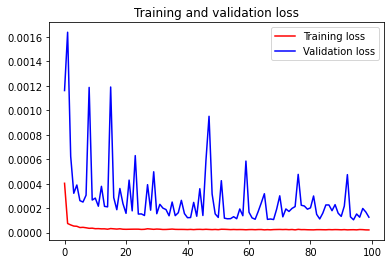

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

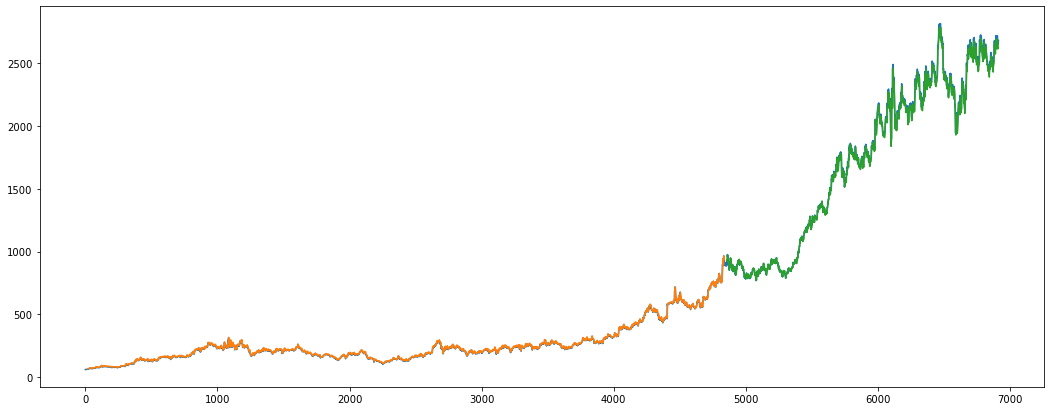

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.31057988, 0.3191597 , 0.3323566 , ..., 0.93788735, 0.94170463,
       0.94143197])

In [49]:
test_predict

array([[ 934.03546],
       [ 922.8796 ],
       [ 936.588  ],
       ...,
       [2627.3928 ],
       [2613.089  ],
       [2621.0002 ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

2054

In [52]:
test_predict1

array([ 934.03546,  922.8796 ,  936.588  , ..., 2627.3928 , 2613.089  ,
       2621.0002 ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.31057988, 0.3191597 , 0.3323566 , ..., 0.93788735, 0.94170463,
        0.94143197]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[ 916.09997559,  939.70001221,  976.        , ..., 2641.60009766,
        2652.10009766, 2651.35009766]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

2054

In [64]:
df2 = df.iloc[4860:,:]

In [65]:
len(df2)

2054

In [66]:
df2.head()

,Open,Close
Date,,
2015-03-05,913.450012,939.700012
2015-03-09,936.000000,976.000000
2015-03-10,978.299988,957.150024
2015-03-11,957.150024,968.900024
2015-03-12,968.000000,960.549988


In [67]:
df2['predicted'] = test_predict1

In [68]:
df2.head(20)

,Open,Close,predicted
Date,,,
2015-03-05,913.450012,939.700012,934.035461
2015-03-09,936.000000,976.000000,922.879578
2015-03-10,978.299988,957.150024,936.588013
2015-03-11,957.150024,968.900024,970.266296
2015-03-12,968.000000,960.549988,964.759766
2015-03-13,963.700012,941.700012,969.471313
2015-03-16,939.450012,931.750000,963.725464
2015-03-17,934.950012,931.799988,946.380737
2015-03-18,932.400024,922.099976,933.357239


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2054 entries, 2015-03-05 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2054 non-null   float64
 1   Close      2054 non-null   float64
 2   predicted  2054 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 56.2 KB


In [70]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,2668.649902,2654.350098,2646.169189
2023-06-23,2651.300049,2641.600098,2645.688965
2023-06-26,2642.149902,2652.100098,2627.392822
2023-06-27,2652.100098,2651.350098,2613.089111
2023-06-30,2665.949951,2678.149902,2621.000244


In [71]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [72]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2015-03-05,913.450012,939.700012,934.035461,-5.664551
2015-03-09,936.000000,976.000000,922.879578,-53.120422
2015-03-10,978.299988,957.150024,936.588013,-20.562012
2015-03-11,957.150024,968.900024,970.266296,1.366272
2015-03-12,968.000000,960.549988,964.759766,4.209778


In [73]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [74]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2015-03-05,913.450012,939.700012,934.035461,-5.664551,0
2015-03-09,936.000000,976.000000,922.879578,-53.120422,0
2015-03-10,978.299988,957.150024,936.588013,-20.562012,0
2015-03-11,957.150024,968.900024,970.266296,1.366272,1
2015-03-12,968.000000,960.549988,964.759766,4.209778,1


In [75]:
df2.drop(columns='temp_signal',inplace = True)

In [76]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2015-03-05,913.450012,939.700012,934.035461,0
2015-03-09,936.000000,976.000000,922.879578,0
2015-03-10,978.299988,957.150024,936.588013,0
2015-03-11,957.150024,968.900024,970.266296,1
2015-03-12,968.000000,960.549988,964.759766,1


In [77]:
signal = list(df2['signal'])

In [78]:
signal

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [79]:
signal.insert(0,999)

In [80]:
signal

[999,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1

In [81]:
len(df2)

2054

In [82]:
len(signal)

2055

In [83]:
signal.pop()

0

In [84]:
len(signal)

2054

In [85]:
new_signal = np.array(signal)

In [86]:
new_signal

array([999,   0,   0, ...,   1,   0,   0])

In [87]:
df2['new_signal'] = new_signal

In [88]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2015-03-05,913.450012,939.700012,934.035461,0,999
2015-03-09,936.000000,976.000000,922.879578,0,0
2015-03-10,978.299988,957.150024,936.588013,0,0
2015-03-11,957.150024,968.900024,970.266296,1,0
2015-03-12,968.000000,960.549988,964.759766,1,1


In [89]:
df2.drop(columns = 'signal',inplace = True)

In [90]:
df3 = df2[df2['new_signal']==1]

In [91]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-12,968.000000,960.549988,964.759766,1
2015-03-13,963.700012,941.700012,969.471313,1
2015-03-16,939.450012,931.750000,963.725464,1
2015-03-17,934.950012,931.799988,946.380737,1
2015-03-18,932.400024,922.099976,933.357239,1


In [92]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [93]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-12,968.000000,960.549988,964.759766,1,-7.450012
2015-03-13,963.700012,941.700012,969.471313,1,-22.000000
2015-03-16,939.450012,931.750000,963.725464,1,-7.700012
2015-03-17,934.950012,931.799988,946.380737,1,-3.150024
2015-03-18,932.400024,922.099976,933.357239,1,-10.300049


In [94]:
df3['profit_loss'].sum()

1002.6006469726562

In [95]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-09,936.000000,976.000000,922.879578,0,-40.000000
2015-03-10,978.299988,957.150024,936.588013,0,21.149963
2015-03-11,957.150024,968.900024,970.266296,0,-11.750000
2015-04-01,873.500000,883.500000,859.122314,0,-10.000000
2015-04-06,883.650024,907.950012,871.561890,0,-24.299988


In [98]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-05,913.450012,939.700012,934.035461,999
2015-03-09,936.000000,976.000000,922.879578,0
2015-03-10,978.299988,957.150024,936.588013,0
2015-03-11,957.150024,968.900024,970.266296,0
2015-03-12,968.000000,960.549988,964.759766,1


In [99]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,2668.649902,2654.350098,2646.169189,0
2023-06-23,2651.300049,2641.600098,2645.688965,0
2023-06-26,2642.149902,2652.100098,2627.392822,1
2023-06-27,2652.100098,2651.350098,2613.089111,0
2023-06-30,2665.949951,2678.149902,2621.000244,0


In [100]:
df4['profit_loss'].sum()

3008.8482055664062

In [101]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [102]:
Total_profit

4011.4488525390625

In [103]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  913.4500122070312
Ending price:  2621.000244140625


In [104]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

1707.5502319335938

In [105]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

2303.8986206054688

In [106]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

57.433079799763796

In [107]:
len(df3)

763

In [108]:
len(df4)

1290

In [109]:
len(df2)

2054